###Data Examination

Data Examination Section
- Load the provided data
- Check values
- Plot the data

In [ ]:
import pandas as pd 
import gdown

gdown.download('https://drive.google.com/uc?id={}'.format('1wdbtj2s9Vst5EQll1oqc1qXx-_tTv7Cf'),'DCOILBRENTEU.csv',quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1wdbtj2s9Vst5EQll1oqc1qXx-_tTv7Cf
To: /content/DCOILBRENTEU.csv
100%|██████████| 143k/143k [00:00<00:00, 41.1MB/s]


'DCOILBRENTEU.csv'

In [ ]:
!ls
!pwd

DCOILBRENTEU.csv  sample_data
/content


In [ ]:
datam = pd.read_csv("DCOILBRENTEU.csv")

In [ ]:
datam.head()

,DATE,DCOILBRENTEU
0,1987-05-20,18.63
1,1987-05-21,18.45
2,1987-05-22,18.55
3,1987-05-25,18.60
4,1987-05-26,18.63


In [ ]:
#datam.describe()
datam[datam.DCOILBRENTEU=='.']

,DATE,DCOILBRENTEU
18,1987-06-15,.
157,1987-12-25,.
162,1988-01-01,.
166,1988-01-07,.
179,1988-01-26,.
...,...,...
8245,2018-12-26,.
8248,2018-12-31,.
8249,2019-01-01,.
8327,2019-04-19,.


In [ ]:
datam = datam[datam.DCOILBRENTEU != "."]
print(datam.shape)

(8156, 2)


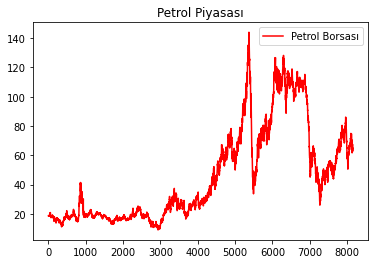

In [ ]:
import matplotlib.pyplot as plt
datam = datam.iloc[:,1].values.astype(float)

plt.plot(datam,color='red',label = 'Petrol Borsası')
plt.title("Petrol Piyasası")
plt.legend()
plt.show()

### Data Preparation

Data Preparation Section
- Find the length of dataset, seperate %10 of the length for testing
- Set sequential hyperparameters
- Implement get_train_length function to get a divisible dataset length with our batch_size.
- Our training data inputs will include the data points to the limit that get_train_length provides. However, for labels, we must put our limit to a higher data point: 

        since for each input time sequence [T : T+window_size]

        corresponding label sequence will be [T+timesteps : T+timesteps+window_size]

        note that in our example window_size = timesteps, reducing our expressions to:

        for each input time sequence [T : T + timesteps]

        corresponding label sequence will be [T+timesteps : T+timesteps*2]

- Get max min values and normalize the data

- Write a loop to form our sequences, according to the input-label time correspondenses that we have just talked about

- Check the shapes of our sequences

- Note that in this example, we form our sequences with replicating the data. Our raw data shape for training was (7340,1) in the beginning, now we have a data with the shape (7296,30,1). This makes each data point in the raw data exist approximately for 30 times in this data.

In [ ]:
import numpy as np
length = len(datam)
print(length)
length *= 1-0.1
print(length)


8156
7340.400000000001


In [ ]:
batch_size = 64
epochs = 120
timesteps = 30

In [ ]:
def get_train_length(dataset,batch_size,test_percent):
  length = len(dataset)
  length *= 1-test_percent
  
  howmanybatches = int(length/batch_size)
  my_train_length = howmanybatches* batch_size

  return my_train_length


In [ ]:
length = get_train_length(datam,batch_size,0.1)
print(length)

7296


In [ ]:
upper_train = length + timesteps * 2
datam_train = datam[:upper_train]


In [ ]:
datam_train = datam_train[:]
datam_train.shape


(7356,)

In [ ]:
print(min(datam_train),max(datam_train))

9.1 143.95


In [ ]:
from sklearn.preprocessing import MinMaxScaler

sc = MinMaxScaler(feature_range = (0,1))
trs = sc.fit_transform(np.float64(datam_train).reshape(-1,1))
trs.shape

print(min(trs),max(trs))

[0.] [1.]


In [ ]:
xtr = []
ytr = []

#print(length+timesteps)

for i in range(timesteps,length+timesteps):
  xtr.append(trs[i-timesteps:i])
  ytr.append(trs[i:i+timesteps])


print(len(xtr))
print(len(ytr))

print(np.shape(xtr[0:2]))
print(np.shape(ytr[0:2]))

xtr = np.array(xtr)
ytr = np.array(ytr)


7296
7296
(2, 30, 1)
(2, 30, 1)


### Network

Network Section
- Setup a 2 hidden layer LSTM network that takes sequences and returns sequences.
- Train the network.
- Plot the results.

In [ ]:
from keras.layers import Dense, Input, LSTM
from keras.models import Model
import h5py


Using TensorFlow backend.


In [62]:
input_1 = Input(batch_shape=(128,timesteps,1),name = 'input')
lstm1 = LSTM(256, stateful = True, return_sequences= True, name = 'lstm_1'  )(input_1)
lstm2 = LSTM(512, stateful = False, return_sequences= True, name = 'lstm_2'  )(lstm1)
output_1 = Dense(1,)(lstm2)

modelim = Model(inputs = input_1, outputs = output_1)

modelim.compile(optimizer = 'adam', loss = 'mae')
modelim.summary()

Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (128, 30, 1)              0         
_________________________________________________________________
lstm_1 (LSTM)                (128, 30, 256)            264192    
_________________________________________________________________
lstm_2 (LSTM)                (128, 30, 512)            1574912   
_________________________________________________________________
dense_9 (Dense)              (128, 30, 1)              513       
Total params: 1,839,617
Trainable params: 1,839,617
Non-trainable params: 0
_________________________________________________________________


In [63]:
import keras
class CustomCallback(keras.callbacks.Callback):
    def on_batch_end(self, epoch, logs=None):
        self.model.reset_states()
        

reset_states = CustomCallback()


In [64]:
modelim.fit(xtr,ytr,shuffle=False,epochs=100,batch_size=128, callbacks=[reset_states])

Epoch 1/100
7296/7296 [==============================] - 3s 376us/step - loss: 0.0639
Epoch 2/100
7296/7296 [==============================] - 2s 327us/step - loss: 0.0577
Epoch 3/100
7296/7296 [==============================] - 2s 324us/step - loss: 0.0681
Epoch 4/100
7296/7296 [==============================] - 2s 324us/step - loss: 0.0782
Epoch 5/100
7296/7296 [==============================] - 2s 328us/step - loss: 0.1066
Epoch 6/100
7296/7296 [==============================] - 2s 327us/step - loss: 0.0986
Epoch 7/100
7296/7296 [==============================] - 2s 325us/step - loss: 0.0862
Epoch 8/100
7296/7296 [==============================] - 2s 328us/step - loss: 0.0930
Epoch 9/100
7296/7296 [==============================] - 2s 321us/step - loss: 0.0785
Epoch 10/100
7296/7296 [==============================] - 2s 326us/step - loss: 0.0779
Epoch 11/100
7296/7296 [==============================] - 2s 324us/step - loss: 0.0753
Epoch 12/100
7296/7296 [============================

KeyboardInterrupt: ignored

In [ ]:
# epochs = 100

# for i in range(epochs):
#   print('Epoch'+str(i))

#   modelim.fit(xtr,ytr,shuffle=False,epochs=1,batch_size=64)
#   modelim.reset_states()

(7296, 30)


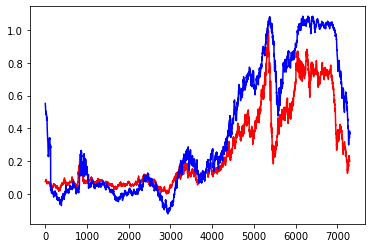

In [65]:
predicted = modelim.predict(xtr,batch_size = 128)
predicted = np.reshape(predicted,(predicted.shape[0],predicted.shape[1]))
print(predicted.shape)

#predicted = sc.inverse_transform(predicted)

# for j in range(0,len(xtr)-timesteps):
#   predict 

predicted[0:len(ytr),0].astype(float)
plt.plot(ytr[0:len(ytr)][:,0,0].astype(float),color = 'red')
plt.plot(predicted[0:len(ytr),0].astype(float),color = 'blue')


### Continuing work

I want to predict on test data here, I will fix this section later.

In [ ]:
# from sklearn.preprocessing import MinMaxScaler

# sc = MinMaxScaler(feature_range = (0,1))
# test = sc.fit_transform(np.float64(datam).reshape(-1,1))
# print(test.shape)

# print(min(test),max(test))


# testx = []
# testy = []

# #print(length+timesteps)

# for i in range(7296+timesteps,7296+768+timesteps):
#   testx.append(test[i-timesteps:i])
#   testy.append(test[i:i+timesteps])


# print(np.shape(testx))
# print(np.shape(testy))

# testx = np.array(testx)[:128,:,:]

# predicted = modelim.predict(testx[:64],batch_size = 64)
# predicted = np.reshape(predicted,(predicted.shape[0],predicted.shape[1]))
# print(predicted.shape)

# #predicted = sc.inverse_transform(predicted)

# draw_pred = np.zeros_like(testx)
# predicted[0:len(testy),0].astype(float)
# draw_pred[30:,:,:] = predicted
# plt.plot(testx[0:len(testx)][:,0,0].astype(float),color = 'blue')
# plt.plot(predicted[0:len(testy)][:,-1].astype(float),color = 'green')



In [ ]:
testx.shape

NameError: ignored

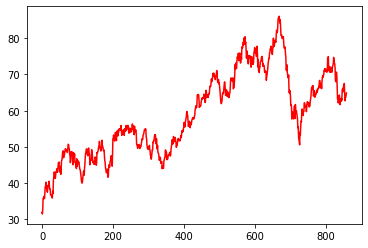

In [ ]:


plt.plot(datam[7296:].astype(float),color = 'red')
plt.plot(predicted[0:len(testy)].astype(float),color = 'blue')
7296